In [1]:
import numpy as np
from urllib.request import urlopen
import scipy.io
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Fetch image and ground truth

In [2]:
url = 'http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat'
r = urlopen(url)
image = scipy.io.loadmat(BytesIO(r.read()))['indian_pines_corrected']

url_gt = 'http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat'
r = urlopen(url_gt)
labels = scipy.io.loadmat(BytesIO(r.read()))['indian_pines_gt']

In [3]:
def data_prepare(gt, im, samples=None):
    classes=np.unique(gt)
    classes = classes[classes != 0]
    
    data = []
    datalabel = np.array([])
    for i in range(len(classes)):
        indices = np.where(gt == classes[i])
        if samples is not None:
            indices = np.array(indices)
            indices = indices.T
            np.random.shuffle(indices)
            indices = indices.T
            B = np.array(indices)[:, :samples]
            indices = tuple(B)
           
        newdata = im[indices[0], indices[1]]
        data.append(newdata)
        datalabel = np.append(datalabel, np.full((newdata.shape[0]), classes[i], dtype=np.uint8),axis=0)
    return np.uint8(np.vstack(data)), np.uint8(datalabel)


def color_image(im):
    colors = [[0, 0, 0],
             [255, 0, 0],
            [255, 255, 0],
            [128, 0, 0],
            [255, 0, 255],
            [0, 0, 255],
            [0, 255, 255],
            [128, 128, 0],
            [0, 128, 128],
            [0, 64, 255],
            [0, 0, 128],
            [0, 128, 255],
            [255, 0, 128],
            [255, 64, 0],
            [50, 150, 220],
            [180, 90, 0],
            [0, 45, 30]]
    
    new_im = np.zeros([145, 145, 3], dtype=int)
    for i in range(np.max(im)):
        indices_class = np.array(np.where(im == i))
        new_im[indices_class[0, :], indices_class[1, :], :]=colors[i]
    return new_im
 
def turn_image(vector, gt):
    classes = np.unique(gt)
    classes = classes[classes != 0]
    indices=None
    for i in range(len(classes)):
            newind = np.array(np.where(gt == classes[i]))

            if indices is None:
                indices = newind
            else:
                indices = np.concatenate(([indices, newind]), axis=1)
    indices = np.transpose(indices)
    new_im = np.zeros([145, 145], dtype=int)
    new_im[indices[:, 0], indices[:, 1]] = vector
    return new_im, indices


def RFclassification(train, test, trainlabel, testlabel):
    clf = RandomForestClassifier(n_estimators=300, max_features='sqrt',
	max_depth=25, min_samples_split=2,n_jobs=12)
    clf.fit(train, trainlabel)
    y_pred = clf.predict(test)
    #visualize(y_pred,i,ref)
    print("Overall Accuracy:", metrics.accuracy_score(testlabel, y_pred))
    print("F1 score for each class",f1_score(testlabel, y_pred, average=None)) 
    plot_confusion_matrix(clf, test, test_label)
    return clf, y_pred

This data has 200 feature for each pixel.

In [4]:
print(np.shape(image))
print(np.shape(labels))

(145, 145, 200)
(145, 145)


# Visualize one sample channel and ground truth 

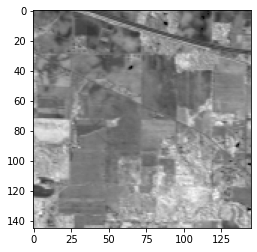

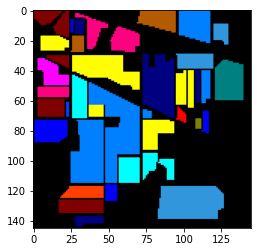

In [5]:
plt.figure()
plt.imshow(image[:, :, 50], cmap='gray')
plt.figure()
plt.imshow(color_image(labels))

In [6]:
test, test_label = data_prepare(labels, image)
train, train_label = data_prepare(labels, image,samples=100)

In [7]:
print(np.shape(test))
print(np.shape(test_label))
print(np.shape(train))
print(np.shape(train_label))

(10249, 200)
(10249,)
(1387, 200)
(1387,)


# Train and display accuracy, f1 score and confusion matrix

Overall Accuracy: 0.6845545906917748
F1 score for each class [0.82882883 0.5890128  0.57726269 0.57585139 0.86540379 0.87762001
 0.90322581 0.92732856 0.72727273 0.58381503 0.57522338 0.54482279
 0.93925234 0.92871366 0.6002805  0.66906475]


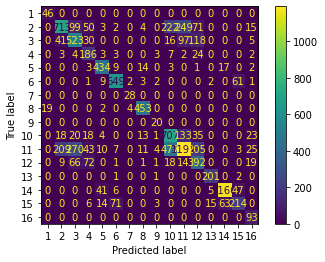

In [8]:
model, y_pred = RFclassification(train, test, train_label, test_label)

# Visualize results

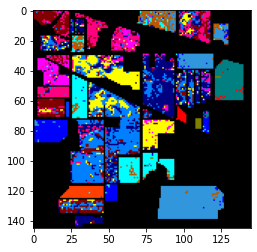

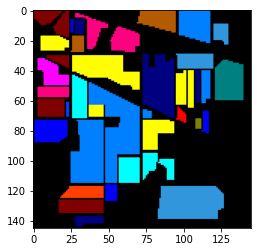

In [9]:
predicted_image, indices = turn_image(y_pred, labels)
plt.figure()
plt.imshow(color_image(predicted_image))
plt.figure()
plt.imshow(color_image(labels))

# Region of Interest

It would be interesting to choose region of interest to look close. Here I will do it manually but in inspector it could be with mouse.

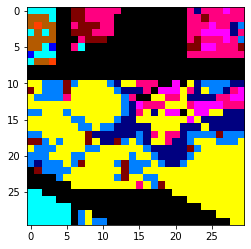

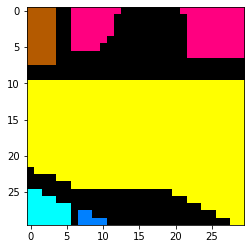

In [10]:
plt.figure()
plt.imshow(color_image(predicted_image)[20:50, 30:60])
plt.figure()
plt.imshow(color_image(labels)[20:50, 30:60])

# Prediction probability for selected location

One may click a pixel to see prediction probability of this location. It is possible to use following ginput command. However, it is not possible in notebook. Therefore, I will select manual location for now.

In [11]:
# from pylab import ginput
# y,x=ginput(1)[0]

In [16]:
location = [20, 30]
a = np.where(indices==location)
model.predict_proba(test)[a]

array([[0.00666667, 0.10666667, 0.24666667, ..., 0.00666667, 0.        ,
        0.02333333],
       [0.        , 0.2       , 0.14333333, ..., 0.        , 0.        ,
        0.00666667],
       [0.        , 0.14666667, 0.20666667, ..., 0.        , 0.        ,
        0.04      ],
       ...,
       [0.00333333, 0.09666667, 0.05666667, ..., 0.        , 0.00333333,
        0.68      ],
       [0.00333333, 0.04666667, 0.02666667, ..., 0.00666667, 0.00666667,
        0.78666667],
       [0.        , 0.07      , 0.02666667, ..., 0.00333333, 0.        ,
        0.76333333]])